# Submission 2


## Input

Sample from every 100th element of the data set for fast development turnaround purpose.

Since each segment contains 150,000 signals (`acoustic_data`), when we take only 1% of the data we only need to handle only 1,500 signals.  The original data set contains a total of 629,145,480 observations, which ends up with a working size of 6,291,454 observations only.  Dividing by 1,500, there are a total of 4194 segments, leaving a the tail of 454 observations that are dropped for analysis.

## Process 

Each segment is summarized by general statistical measures.  

- minimum
- maximum
- mean
- skewness
- variance
- quantile 0%, 20%, 40%, 60%, 80%, 100%
- moment 2, 3, 4, 5

At the end of the process, we should have turned the 6.3 million rows of signal data into 4,194 rows of summarized data with 12 feature columns.  

What do we use for the `y`?  I have chosen to use the last `time_to_failure` records in the segment given that the value intuitively was influenced by the previous records in the segment.

## Model

The XGBoost model is used in this submission.  XGBoost comes with [a lot of learning parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#).  For the sake of this exercise, only a couple was tweaked and examined manually.  In the future, it should be done more automatically e.g. using the `nfold_cv` function for cross validation.

In this notebook, we have worked with the tuning parameters. Also, the number of rounds of training has been examined to find the optimal result.

1. eta
2. max_depth

I used the K-fold method with `k = 10` for evaluating the prediction.  So each specific model comes back with 11 results.  Note that it has 11 results rather than 10 because the fold is uneven i.e. 4194 ÷ 10 gives 419 samples per fold and it leaves the last 4 records strangling. For the purpose of this exercise, I ignored this relatively minor effect.

**The hyper parameter tuning procedure is very naive.**  First, I started with 10 rounds of training with `max_depth` of 6 (which is the default value anyways) and tried a range of `eta` values.  The result was plotted and an optimal value of `eta` was chosen.  I happened to picked `eta = 0.9` but it's arguable whether that's the right value.  Then, I fixed `eta` and varied the different `max_depth`'s.  Finally, I searched for the best `num_rounds` by fixing both `eta` and `max_dpath` to the chosen values.  At the end of the tuning exercise, I have chosen all tuning parameters and run K-fold CV once again.  The most accurate model (#7) was finally chosen based upon the evaluation result.

## Results

The MAE for the chosen model was 1.637.  

The submission to Kaggle ends up with a score of 1.852, which is an improvement from submission1's 1.926.  However, it's not better than Arthur's previous submission with score of 1.586 (rank 1912 at the time of this writing).

## Afterthoughts and Ideas for the Next Round

Data
1. Consider using all 629 million rows 
2. Create new data by introducing a rolling window.  For example, discard the first 75,000 rows from the original data set and collect 150,000 segments, effectively shifting the data set by about 50% of each segment.
3. Remove segments that contains the earthquake e.g. abs(maximum(time_to_failure) - minimum(time_to_failure)) > 5
4. Store summary statistics to persistent storage such as S3 for reuse.  There is no need to keep calculating them all the time.  This is more desirable when we start using the complete data set.

Features Engineering
1. Investigate and consider adding FFT 
2. Center and scale features
3. Take the log of the `acoustic_data` since it varies a lot dramatically
4. Run linear regression and take the intercept and slope coefficient

Dependent variable
1. Predict median or mean of the segments rather than using the last value

Issues 
1. See the bottom chart.  Not sure why the predictions looks like layers of horizontal lines. 

In [1]:
using CSVFiles
using DataFrames
using Statistics
using StatsBase
using Printf
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
# Define some functions to handling chunks

home_dir = "/efs/tkwong/kaggle/LANL-Earthquake-Competition/"
fpath(filename) = home_dir * filename
read(filename) = load(fpath(filename)) |> DataFrame

"""
Divide the raw data frame `df` into chunks of `chunk_size`.
Derive new features for the chunk and a single `y` value in first column.
"""
function process_chunks(df, chunk_size, maxobs = 1_000_000)
    nobs = min(maxobs, nrow(df) ÷ chunk_size)
    input =  allocate_input_grid(nobs)
    Threads.@threads for chunk_idx in 1:nobs
        acoustic_data, time_to_failure = get_chunk(df, chunk_size, chunk_idx)
        process_single_chunk!(input, acoustic_data, time_to_failure, chunk_idx)
    end
    return input
end

"""
Get a single chunk of data
"""
function get_chunk(df, chunk_size, chunk_idx)
    start_idx = (chunk_idx - 1) * chunk_size + 1
    end_idx = start_idx + chunk_size - 1
    return (@view(df[start_idx:end_idx, :acoustic_data]), 
            @view(df[start_idx:end_idx, :time_to_failure]))
end

"""
Generate a single feature by running function `func` over the chunks
from data frame `df`.  Each chunk is of size `chunk_size`.  
"""
function chunk_stat(source, df, chunk_size, func, label) 
    num_chunks = nrow(df) ÷ chunk_size
    feature = fill(0.0, num_chunks)
    Threads.@threads for chunk_idx in 1:num_chunks
        acoustic_data, time_to_failure = get_chunk(df, chunk_size, chunk_idx)
        feature[chunk_idx] = func(source == :signal ? acoustic_data : time_to_failure) 
    end
    return DataFrame((label => feature,)...)
end

"""
Center and scale a vector
"""    
function center_and_scale(x::Vector{T}) where T <: Real
    μ, σ = mean_and_std(x)
    return @. (x - μ) / σ
end
;

In [3]:
@time df = read("train_100th.csv");

 14.230034 seconds (49.66 M allocations: 2.443 GiB, 13.79% gc time)


In [15]:
function features(v)
    flist = [
        (minimum, :minimum),
        (maximum, :maximum),
        (mean, :mean),
        (skewness, :skewness),
        (var, :var),
        (kurtosis, :kurtosis),
        (x->quantile(x, 0.0), :q00),
        (x->quantile(x, 0.2), :q02),
        (x->quantile(x, 0.4), :q04),
        (x->quantile(x, 0.6), :q06),
        (x->quantile(x, 0.8), :q08),
        (x->quantile(x, 1.0), :q10),
        (x->moment(x, 2), :mo2),
        (x->moment(x, 3), :mo3),
        (x->moment(x, 4), :mo4),
        (x->moment(x, 5), :mo5),
    ]
    df = DataFrame()
    for f in flist
        df[f[2]] = f[1](v)
    end
    df
end

function compress(df::AbstractDataFrame)
    # detect if the data frame is large one, or a 100th-sample one
    chunk_size = nrow(df) > 600_000_000 ? 150_000 : 1_500
    
    # create compressed data frame
    return hcat(
        chunk_stat(:quake,  df, chunk_size, x -> x[end], :y),
        chunk_stat(:signal, df, chunk_size, minimum, :minimum),
        chunk_stat(:signal, df, chunk_size, maximum, :maximum),
        chunk_stat(:signal, df, chunk_size, mean, :mean),
        chunk_stat(:signal, df, chunk_size, skewness, :skewness),
        chunk_stat(:signal, df, chunk_size, var, :var),
        chunk_stat(:signal, df, chunk_size, kurtosis, :kurtosis),
        chunk_stat(:signal, df, chunk_size, x->quantile(x, 0.0), :q00),
        chunk_stat(:signal, df, chunk_size, x->quantile(x, 0.2), :q02),
        chunk_stat(:signal, df, chunk_size, x->quantile(x, 0.4), :q04),
        chunk_stat(:signal, df, chunk_size, x->quantile(x, 0.6), :q06),
        chunk_stat(:signal, df, chunk_size, x->quantile(x, 0.8), :q08),
        chunk_stat(:signal, df, chunk_size, x->quantile(x, 1.0), :q10),
        chunk_stat(:signal, df, chunk_size, x->moment(x, 2), :mo2),
        chunk_stat(:signal, df, chunk_size, x->moment(x, 3), :mo3),
        chunk_stat(:signal, df, chunk_size, x->moment(x, 4), :mo4),
        chunk_stat(:signal, df, chunk_size, x->moment(x, 5), :mo5),
    )   
end

compressed_df = compress(df)
# display(first(compressed_df, 5))
# display([c => summarystats(compressed_df[c]) for c in names(compressed_df)])

,y,minimum,maximum,mean,skewness,var,kurtosis,q00,q02,q04,q06,q08,q10,mo2,mo3,mo4,mo5
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.4308,-92.0,44.0,5.022,-3.40678,29.9295,71.1109,-92.0,2.0,4.0,6.0,8.0,44.0,29.9095,-557.26,66298.1,-5.681e6
2,1.3915,-80.0,137.0,4.81933,3.78102,44.8646,121.352,-80.0,2.0,4.0,6.0,8.0,137.0,44.8347,1135.09,2.49966e5,2.39436e7
3,1.3532,-69.0,91.0,4.81333,0.394757,51.4608,34.0318,-69.0,2.0,4.0,6.0,8.0,91.0,51.4265,145.583,97937.5,2.27269e6
4,1.3138,-68.0,86.0,5.18133,0.147251,39.9151,43.8663,-68.0,2.0,4.0,6.0,8.0,86.0,39.8885,37.0961,74568.4,5.92618e5
5,1.2744,-72.0,118.0,5.06467,3.25275,56.0432,56.5143,-72.0,2.0,4.0,6.0,8.0,118.0,56.0058,1363.33,1.86676e5,1.28253e7
6,1.2361,-46.0,55.0,5.0,0.917727,29.01,18.5957,-46.0,2.0,4.0,6.0,8.0,55.0,28.9907,143.252,18150.3,2.09153e5
7,1.1968,-26.0,41.0,4.818,0.685404,30.3544,8.42093,-26.0,2.0,4.0,6.0,8.0,41.0,30.3342,114.511,10509.1,1.32801e5
8,1.1585,-81.0,65.0,4.51467,-3.20815,34.8343,65.1198,-81.0,2.0,4.0,5.0,7.0,65.0,34.8111,-658.918,82548.5,-4.96351e6
9,1.1191,-99.0,71.0,4.96067,-0.341557,59.2653,40.2795,-99.0,1.0,4.0,6.0,8.0,71.0,59.2258,-155.679,1.51811e5,-6.29248e6


In [16]:
# custom k-fold split function

function kfold(df::AbstractDataFrame; k = 10)
    r = nrow(df)
    n = r ÷ k
    return (rows = r, fold_size = n, folds = r ÷ n + 1, k = k)
end

function split_kfold(df::AbstractDataFrame, fold, i)
    test_start = fold.fold_size * (i-1) + 1
    test_end = test_start + fold.fold_size - 1
    if test_end > fold.rows
        test_end = fold.rows
    end
    keep = fill(false, fold.rows)
    keep[test_start:test_end] .= true
    return (test = df[keep, :], train = df[.!keep, :])
end

# v = DataFrame(x=1:25)
# fold = kfold(v)
# test, train = split_kfold(v, fold, 2)

split_kfold (generic function with 1 method)

In [17]:
using XGBoost

function tune(; num_round = 10, eta = 0.3, max_depth = 6)
    fold = kfold(compressed_df)
    mae = Float64[]
    models = []
    for i in 1:fold.folds

        test_df, train_df = split_kfold(compressed_df, fold, i)

        train_X = convert(Matrix, train_df[2:end])
        train_Y = train_df[1]
        bst = xgboost(train_X, num_round, label=train_Y, 
                eta=eta, max_depth=max_depth, silent=1)

        test_X = convert(Matrix, test_df[2:end])
        test_Y = test_df[1]

        pred_Y = XGBoost.predict(bst, test_X)

        push!(mae, sum(abs.(pred_Y .- test_Y)) / length(pred_Y))
        push!(models, bst)
    end
    (mae = mae, models = models)
end

tune(num_round = 10, eta = 0.3, max_depth = 6)

(mae = [2.63564, 2.04971, 2.24933, 2.94142, 3.23929, 2.03714, 1.56344, 1.59351, 3.36996, 2.03278, 1.61511], models = Any[Booster(Ptr{Nothing} @0x000000000737da20), Booster(Ptr{Nothing} @0x0000000006cd78e0), Booster(Ptr{Nothing} @0x00000000078dc290), Booster(Ptr{Nothing} @0x00000000089995d0), Booster(Ptr{Nothing} @0x00000000080df4d0), Booster(Ptr{Nothing} @0x00000000080711d0), Booster(Ptr{Nothing} @0x0000000008c47190), Booster(Ptr{Nothing} @0x0000000007aa9490), Booster(Ptr{Nothing} @0x0000000007c95b10), Booster(Ptr{Nothing} @0x000000000704ded0), Booster(Ptr{Nothing} @0x0000000006914f10)])

In [18]:
using StatsPlots

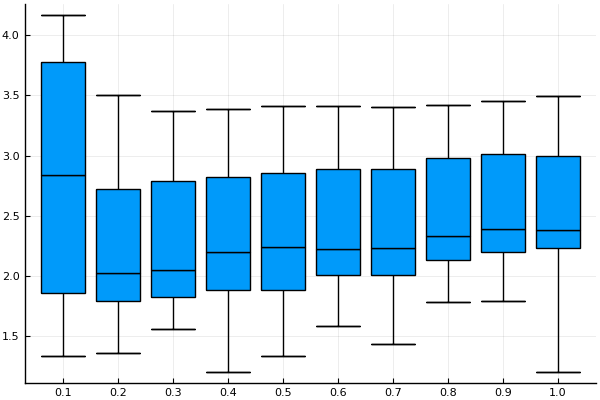

In [19]:
v = DataFrame(eta=String[], mae=Float64[])
for eta in 0.1:0.1:1.0
    mae, models = tune(num_round = 10, eta = eta, max_depth = 6)
    w = DataFrame(eta=string(eta), mae=mae)
    v = vcat(v, w)
end
@df v boxplot(:eta, :mae, legend = false)

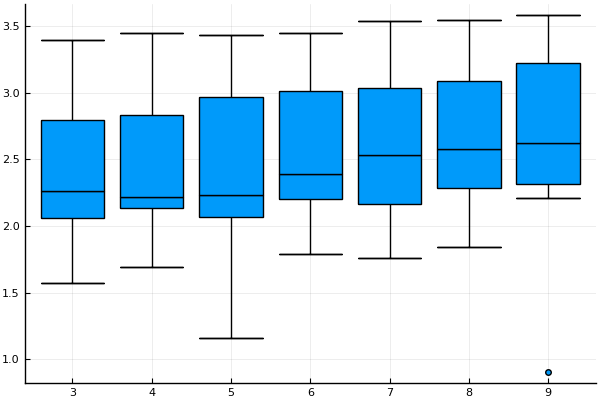

In [20]:
v = DataFrame(max_depth=String[], mae=Float64[])
for d in 3:9
    mae, models = tune(num_round = 10, eta = 0.9, max_depth = d)
    w = DataFrame(max_depth=string(d), mae=mae)
    v = vcat(v, w)
end
@df v boxplot(:max_depth, :mae, legend = false)

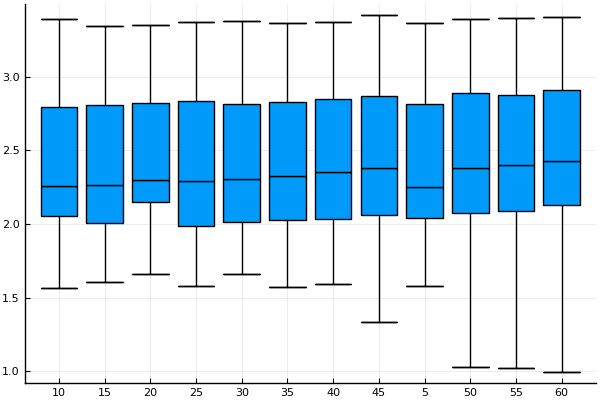

In [21]:
v = DataFrame(rounds=String[], mae=Float64[])
for d in 5:5:60
    mae, models = tune(num_round = d, eta = 0.9, max_depth = 3)
    w = DataFrame(rounds=@sprintf("%0d",d), mae=mae)
    v = vcat(v, w)
end
@df v boxplot(:rounds, :mae, legend = false)

In [22]:
mae, models = tune(num_round = 5, eta = 0.9, max_depth = 4)
@show mae

mae = [2.55841, 2.1134, 2.14249, 3.10512, 3.20384, 2.08999, 1.63662, 1.75749, 3.34707, 2.29533, 2.50898]


11-element Array{Float64,1}:
 2.558408467707303 
 2.1134034496425005
 2.142490027156324 
 3.1051218963421783
 3.2038443462727897
 2.0899872586259685
 1.6366215367132553
 1.7574868893218303
 3.347074662928014 
 2.2953252682355374
 2.5089751305039423

In [23]:
best_model = models[7]

Booster(Ptr{Nothing} @0x000000000a5a84d0)

In [24]:
t1 = read("test/seg_00030f.csv")
t1 = t1[1:100:end, :]   # trim?  do it for now
f1 = features(t1[:acoustic_data])
XGBoost.predict(best_model, convert(Matrix, f1))

1-element Array{Float32,1}:
 6.4327993

In [25]:
t1 = read("test/seg_0012b5.csv")
t1 = t1[1:100:end, :]   # trim?  do it for now
f1 = features(t1[:acoustic_data])
XGBoost.predict(best_model, convert(Matrix, f1))

1-element Array{Float32,1}:
 4.5277624

In [26]:
result = DataFrame(seg_id=String[], time_to_failure=Float64[])
for file in readdir("test")
    m = match(r"(seg.*)\.csv", file)
    if !isnothing(m)
        t = read("test/" * file)
        t = t[1:100:end, :]
        f = features(t[:acoustic_data])
        v = XGBoost.predict(best_model, convert(Matrix, f))
        push!(result, (seg_id=m[1], time_to_failure=v[1]))
    end
end
result

,seg_id,time_to_failure
,String,Float64
1,seg_00030f,6.4328
2,seg_0012b5,4.52776
3,seg_00184e,6.64601
4,seg_003339,8.41358
5,seg_0042cc,5.25555
6,seg_004314,1.89937
7,seg_004cd2,0.814425
8,seg_004ee5,5.57578
9,seg_004f1f,5.43514


In [27]:
open("submission2.csv", "w") do f
    println(f, "seg_id,time_to_failure")
    for i in 1:nrow(result)
        println(f, result[i, :seg_id], ",", result[i, :time_to_failure])
    end
end

## Additional Analysis _before_ Submission

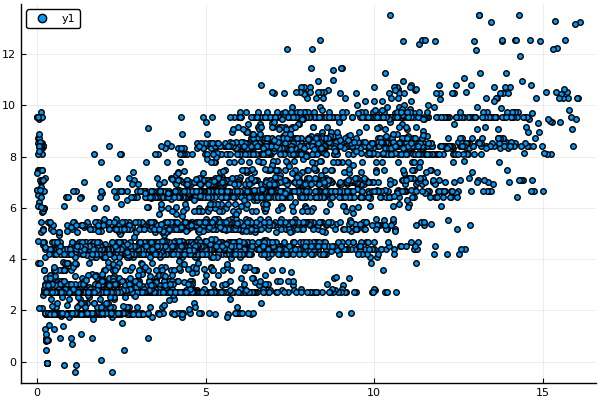

In [28]:
X = convert(Matrix, compressed_df[2:end])
pred_Y = XGBoost.predict(best_model, X)
scatter(compressed_df[:y], pred_Y)